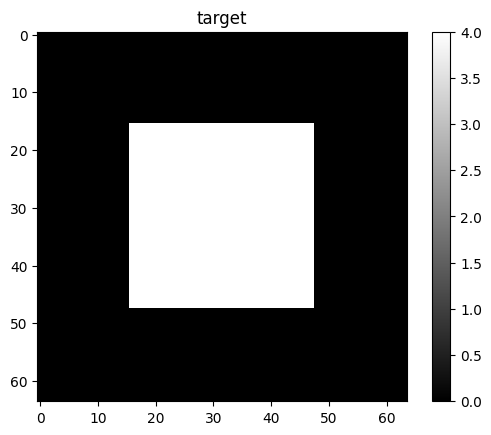

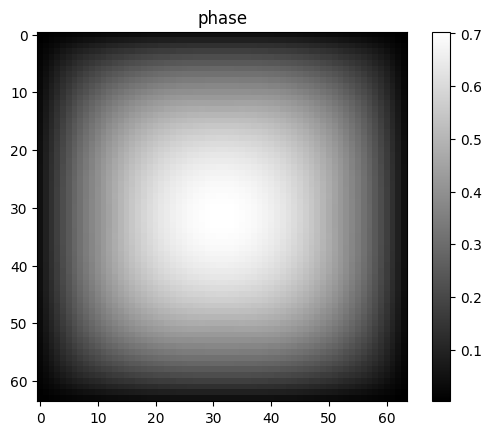

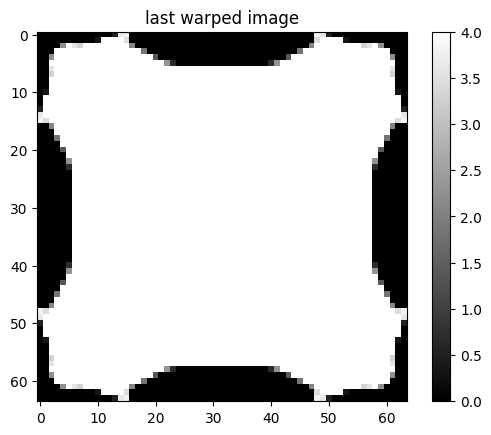

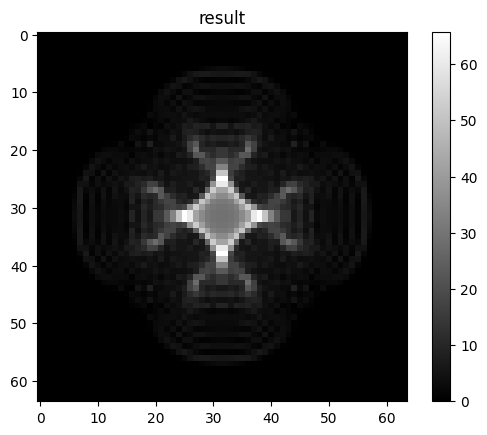

[[ 6.10107045e-04  6.71175467e-05  1.43347946e-03 -3.45298033e-04  1.30009844e-03 -1.45433104e-03  3.76013331e-04 -2.79849740e-03 -3.73192241e-04 -3.46560757e-03 -1.73871793e-04 -3.25977361e-03  3.56897812e-04  1.16775151e-01  2.16360519e-01  8.73148145e-01  2.62393845e-01  3.05297986e+00  3.99826552e+00  3.99805515e+00  4.00120777e+00  4.00257974e+00  4.00559951e+00  4.00635692e+00  4.00817630e+00  4.00717047e+00  4.00794927e+00  4.00609057e+00  4.00672511e+00  4.00539669e+00  4.00600597e+00  4.00559816e+00  4.00559814e+00  4.00600598e+00  4.00539668e+00  4.00672513e+00  4.00609055e+00  4.00794929e+00  4.00717045e+00  4.00817632e+00  4.00635690e+00  4.00559953e+00  4.00257972e+00  4.00120779e+00  3.99805513e+00  3.99826554e+00  3.05297983e+00  2.62393866e-01  8.73151939e-01  2.16352910e-01  1.16775131e-01  3.56916542e-04 -3.25979211e-03 -1.73855049e-04 -3.46562368e-03 -3.73177878e-04 -2.79851010e-03  3.76025030e-04 -1.45433978e-03  1.30010710e-03 -3.45303074e-04  1.43348474e-03  6.711

In [2]:
#the third optimal method
import cv2 as op    #图像处理
import numpy as np #数组矩阵处理
from scipy.sparse.linalg import bicgstab    #共轭梯度法
import matplotlib.pyplot as plt #灰度图显示
import math

#预先准备函数部分
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

#线性插值
def single_biline(x,x0,x1,in1,in2):
    alpha=abs(x-x0)
    y=alpha*in2+(1-alpha)*in1
    return y

#二维laplacian算子
def discrete_laplacian_2d_matrix(m, n):
    """
    生成一个m x n的二维离散拉普拉斯算子的系统矩阵。
    参数:
    m, n -- 矩阵的行和列的大小
    返回:
    L -- 二维离散拉普拉斯算子的系统矩阵
    """
    # 初始化矩阵
    L = np.zeros((m * n, m * n))
    
    # 遍历每个像素点
    for i in range(m):
        for j in range(n):
            idx = i * n + j  # 当前像素的索引
            # 计算拉普拉斯算子
            if i > 0:  # 上
                L[idx, idx - n] = 1
            if i < m - 1:  # 下
                L[idx, idx + n] = 1
            if j > 0:  # 左
                L[idx, idx - 1] = 1
            if j < n - 1:  # 右
                L[idx, idx + 1] = 1
            # 主对角线元素
            L[idx, idx] = -4
    
    return L

#定义目标图像和入射光束平面光强,每个单元格边长为160um,比例为6250:1,焦距应为20cm，同时按照比例来定义程序下焦距
row=64  #行
col=64  #列
target=np.zeros((row,col))
target[16:48,16:48]=4#目标光强
#im_map=target.copy()#扭曲的图像结果
f=1250#按照比例折算而来，为离散化坐标系下定义焦距
incident=np.ones((row,col))#入射平面光束照度分布

#incident[1:30,1:30]=-3 验证负数是否可以用plt表示出来



#光源平面索引下标
I=np.tile(np.arange(row).reshape(row,1),(1,col))#代表y
J=np.tile(np.arange(col),(row,1))#代表x
#print(I)
#print(J)
#光源平面实际物理坐标(1:160um)
X=J*0.00016
Y=I*0.00016

#laplacian矩阵
L_2D=discrete_laplacian_2d_matrix(row,col)

#迭代进行优化
im_map=target.copy()
for count in range(1,6):
    target_delete=-im_map+np.ones((row,col))
    #把原来图像化成列向量
    target_col=target_delete.reshape(-1,1)
    #使用双共轭梯度稳定迭代法求解 Ax = b
    p,exitcode=bicgstab(L_2D,target_col,atol=1)
    
    #求出p(x)，需要除去焦距,并且由列向量转为矩阵
    p=p/f
    p=p.reshape(row,col)
    
    # 计算矩阵 p 的 梯度，并乘以实际的焦距长度（0.2m）
    dp_dx = f*np.gradient(p, axis=1)  # x 方向上即水平的梯度
    dp_dy = f*np.gradient(p, axis=0)  # y 方向上即竖直方向的梯度
    
    #print(dp_dx)
    #print(dp_dy)
    #print(I)#I记录的应当是y坐标
    #print(J)#J记录的是x坐标
    
     # 映射后的目标平面实际物理坐标
    X_T = (J + dp_dx).astype(np.float32)
    Y_T = (I + dp_dy).astype(np.float32)
    #print(X_T)
    #print(Y_T)
    #转为目标平面索引坐标
    J_T=X_T
    I_T=Y_T
    
    # 双线性插值,扭曲原来的图像
    im_map_cp=np.zeros((row,col))
    for ci in range(0,row):
        for cj in range(0,col):
          #边界溢出处理,I代表y,J代表x
          if I_T[ci,cj]<0:
                I_T[ci,cj]=0
          if I_T[ci,cj]>row-1:
                I_T[ci,cj]=row-1
          if J_T[ci,cj]<0:
                J_T[ci,cj]=0
          if J_T[ci,cj]>col-1:
                J_T[ci,cj]=col-1
                
          #边界处理完毕后开始正式处理
          y0=int(math.floor(I_T[ci,cj]))
          y1=int(math.ceil(I_T[ci,cj]))
          x0=int(math.floor(J_T[ci,cj]))
          x1=int(math.ceil(J_T[ci,cj]))
          
          #将坐标对应到image_target上的强度
          in_1=target[y0,x0]
          in_2=target[y0,x1]
          in_3=target[y1,x0]
          in_4=target[y1,x1]
          
          p1=single_biline(J_T[ci,cj],x0,x1,in_1,in_2)
          p2=single_biline(J_T[ci,cj],x0,x1,in_3,in_4)
          p3=single_biline(I_T[ci,cj],y0,y1,p1,p2)
          im_map_cp[ci,cj]=p3
    im_map=im_map_cp.copy()     
    #图像扭曲完毕后，重新进行迭代
          
 
#结果检测准备部分，将要分配的光强进行获取
p_temp=p.reshape(-1,1)
p_temp=np.dot(L_2D,p_temp)
p_temp=p_temp.reshape(row,col)  
value=np.ones((row,col))-p_temp*f   #1-f*laplacian*p(x)

#value=1/value
#定义映射平面，初始置为0
result=np.zeros((row,col))

#X_T,Y_T存储映射后的坐标，非整数，故需要进行二次插值
for ci in range(0,row):
    for cj in range(0,col):
        x_out=X_T[ci,cj]
        y_out=Y_T[ci,cj]
        
        #x_out,y_out的边界处理,不过一般会确保映射平面幕布足够大
        if x_out<0:
            x_out=0 
        if x_out>col-1:
            x_out=col-1
        if y_out<0:
            y_out=0
        if y_out>row-1:
            y_out=row-1
        
        #边界处理完毕后开始正式处理
        intensity=value[ci,cj]
        
        x0=int(math.floor(x_out))
        x1=int(math.ceil(x_out))
        y0=int(math.floor(y_out))
        y1=int(math.ceil(y_out))
        
        #二次线性插值，注意是+
        result[x0,y0]=result[x0,y0]+intensity*(1-abs(x_out-x0))*(1-abs(y_out-y0))
        result[x1,y0]=result[x1,y0]+intensity*(1-abs(x_out-x1))*(1-abs(y_out-y0))
        result[x0,y1]=result[x0,y1]+intensity*(1-abs(x_out-x0))*(1-abs(y_out-y1))
        result[x1,y1]=result[x1,y1]+intensity*(1-abs(x_out-x1))*(1-abs(y_out-y1))
        
        
#检验结果
#画图核实入射光束以及目标光强
plt.imshow(target, cmap='gray')
plt.colorbar()
plt.title('target')
plt.show()
          
#相位函数
plt.imshow(p, cmap='gray')
plt.colorbar()
plt.title('phase')
plt.show()
#映射结果
plt.imshow(im_map, cmap='gray')
plt.colorbar()
plt.title('last warped image')
plt.show()
#最终结果
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title('result')
plt.show()

print(value)
print(X_T)
print(Y_T)

In [49]:
import cv2 as op    #图像处理
import numpy as np #数组矩阵处理
import math
from scipy import ndimage #求各方向梯度

# row=5
# col=5
# I=np.tile(np.arange(row).reshape(row,1),(1,col))
# print(I)
# I=I.reshape(-1,1)
# J=np.tile(np.arange(col),(row,1))

# print(I)

p = np.array([[2, 2, 2],
              [4, 5, 6],
              [7, 8, 9]])
p1 = np.array([[2, 0, 0],
              [0, 5, 0],
              [0, 0, 9]])

print(np.dot(p,p1))
print(np.gradient(p, axis=0))



print(p[1,0])


[[ 4 10 18]
 [ 8 25 54]
 [14 40 81]]
[[2.  3.  4. ]
 [2.5 3.  3.5]
 [3.  3.  3. ]]
4
